Using device: cuda


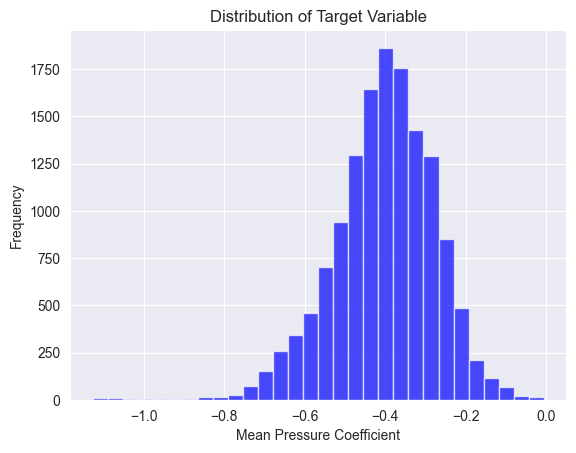

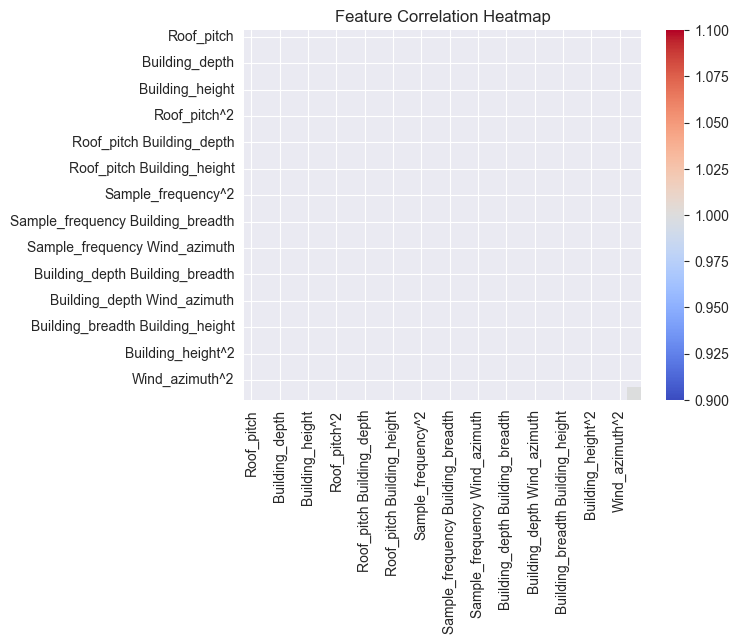

Fitting 3 folds for each of 50 candidates, totalling 150 fits
XGBoost - Best Params: {'subsample': 0.6, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.2, 'colsample_bytree': 1.0}
XGBoost - MAE: 0.0958, MAPE: 0.3160, MSE: 0.0156, R²: -0.0000
Epoch [1/100], Train Loss: 0.0498, Val Loss: 0.0156
Epoch [2/100], Train Loss: 0.0196, Val Loss: 0.0156
Epoch [3/100], Train Loss: 0.0193, Val Loss: 0.0157
Epoch [4/100], Train Loss: 0.0191, Val Loss: 0.0157
Epoch [5/100], Train Loss: 0.0192, Val Loss: 0.0157
Epoch [6/100], Train Loss: 0.0187, Val Loss: 0.0158
Epoch [7/100], Train Loss: 0.0188, Val Loss: 0.0156
Epoch [8/100], Train Loss: 0.0185, Val Loss: 0.0157
Epoch [9/100], Train Loss: 0.0185, Val Loss: 0.0156
Epoch [10/100], Train Loss: 0.0182, Val Loss: 0.0159
Epoch [11/100], Train Loss: 0.0181, Val Loss: 0.0156
Epoch [12/100], Train Loss: 0.0182, Val Loss: 0.0156
Epoch [13/100], Train Loss: 0.0180, Val Loss: 0.0157
Epoch [14/100], Train Loss: 0.0180, Val Loss: 0.0157
Epoch [15/100], T

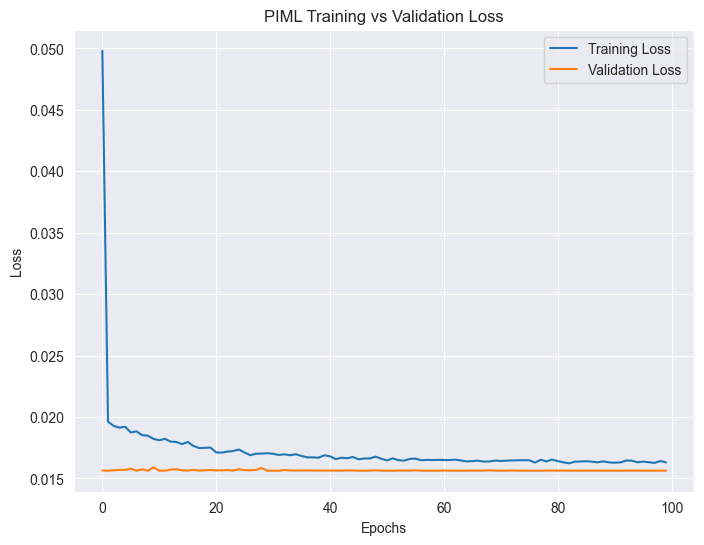

PIML - MAE: 0.0957, MAPE: 0.3131, MSE: 0.0156, R²: -0.0004


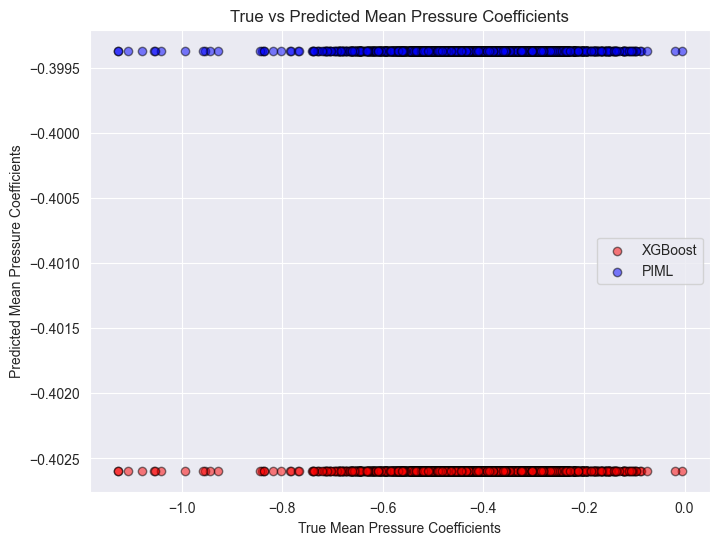

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from scipy.io import loadmat
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score, accuracy_score

# Check for GPU availability
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# --- Data Loading ---
data_path = "../data/Low-rise with eaves/roof type o/height 1;4/Cp_ts_ROH06_deg023.mat"
mat_data = loadmat(data_path)

# Extract fields
roof_pitch = mat_data['Roof_pitch'].flatten()
sample_frequency = mat_data['Sample_frequency'].flatten()
building_depth = mat_data['Building_depth'].flatten()
building_breadth = mat_data['Building_breadth'].flatten()
building_height = mat_data['Building_height'].flatten()
wind_azimuth = mat_data['Wind_azimuth'].flatten()
wind_pressure_coefficients = mat_data['Wind_pressure_coefficients']

mean_pressure_coefficients = wind_pressure_coefficients.mean(axis=1)

# Data Quality Check
plt.hist(mean_pressure_coefficients, bins=30, color='blue', alpha=0.7)
plt.xlabel("Mean Pressure Coefficient")
plt.ylabel("Frequency")
plt.title("Distribution of Target Variable")
plt.grid(True)
plt.show()

# Ensure each feature has the same length
num_samples = mean_pressure_coefficients.shape[0]
features = pd.DataFrame({
    "Roof_pitch": np.tile(roof_pitch, num_samples // len(roof_pitch)),
    "Sample_frequency": np.tile(sample_frequency, num_samples // len(sample_frequency)),
    "Building_depth": np.tile(building_depth, num_samples // len(building_depth)),
    "Building_breadth": np.tile(building_breadth, num_samples // len(building_breadth)),
    "Building_height": np.tile(building_height, num_samples // len(building_height)),
    "Wind_azimuth": np.tile(wind_azimuth, num_samples // len(wind_azimuth)),
})
features["Mean_pressure_coefficient"] = mean_pressure_coefficients

# Polynomial Features
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.fit_transform(features.drop(columns=["Mean_pressure_coefficient"]))
feature_names = poly.get_feature_names_out(features.drop(columns=["Mean_pressure_coefficient"]).columns)
poly_df = pd.DataFrame(poly_features, columns=feature_names)
poly_df["Mean_pressure_coefficient"] = mean_pressure_coefficients

# Correlation Analysis
corr_matrix = poly_df.corr()
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()

# --- Train-Test Split ---
X = poly_df.drop(columns=["Mean_pressure_coefficient"])
y = poly_df["Mean_pressure_coefficient"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- XGBoost Model ---
params = {
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 300, 500],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=params, n_iter=50, cv=3, scoring='r2', verbose=1, random_state=42)
random_search.fit(X_train_scaled, y_train)

best_xgb = random_search.best_estimator_
y_pred_xgb = best_xgb.predict(X_test_scaled)

mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
mape_xgb = mean_absolute_percentage_error(y_test, y_pred_xgb)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"XGBoost - Best Params: {random_search.best_params_}")
print(f"XGBoost - MAE: {mae_xgb:.4f}, MAPE: {mape_xgb:.4f}, MSE: {mse_xgb:.4f}, R²: {r2_xgb:.4f}")

# --- Physics-Informed Machine Learning (PIML) ---
class PressureDataset(Dataset):
    def __init__(self, features, targets):
        self.features = torch.tensor(features, dtype=torch.float32).to(device)
        self.targets = torch.tensor(targets, dtype=torch.float32).to(device)

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

train_dataset = PressureDataset(X_train_scaled, y_train.values)
test_dataset = PressureDataset(X_test_scaled, y_test.values)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define PyTorch model
class RegressionModel(nn.Module):
    def __init__(self, input_size):
        super(RegressionModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.dropout = nn.Dropout(0.3)
        self.fc4 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.dropout(torch.relu(self.fc3(x)))
        x = self.fc4(x)
        return x

model = RegressionModel(input_size=X_train_scaled.shape[1]).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

# Train PIML model
num_epochs = 100
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    for features, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    train_losses.append(epoch_loss / len(train_loader))

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for features, targets in test_loader:
            outputs = model(features)
            val_loss += criterion(outputs.squeeze(), targets).item()

    val_losses.append(val_loss / len(test_loader))
    scheduler.step()
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

# Plot Training vs Validation Loss
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("PIML Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

# Evaluate PIML model
y_pred_p = []
y_true_p = []
model.eval()
with torch.no_grad():
    for features, targets in test_loader:
        outputs = model(features)
        y_pred_p.append(outputs.squeeze().cpu().numpy())
        y_true_p.append(targets.cpu().numpy())

y_pred_p = np.concatenate(y_pred_p)
y_true_p = np.concatenate(y_true_p)

c

# --- Comparison Plot ---
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_xgb, alpha=0.5, color='red', edgecolor='k', label='XGBoost')
plt.scatter(y_true_p, y_pred_p, alpha=0.5, color='blue', edgecolor='k', label='PIML')
plt.xlabel("True Mean Pressure Coefficients")
plt.ylabel("Predicted Mean Pressure Coefficients")
plt.title("True vs Predicted Mean Pressure Coefficients")
plt.legend()
plt.grid(True)
plt.show()
